# Training Log Analysis Notebook
Parses logs from training epochs, computes per-model statistics, and visualizes:
- Smoothed average reward
- Smoothed average loss
- Smoothed win rate
- Summary statistics per model

In [9]:
import re
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="darkgrid")

In [10]:
# Load and parse the log file
log_path = 'training_log.txt'
with open(log_path, 'r') as f:
    lines = f.readlines()

records = []
float_pattern = r"-?\d+\.\d+"

for epoch_idx, line in enumerate(lines):
    games_match = re.search(r"Games Played:\s+(\d+)", line)
    games_played = int(games_match.group(1)) if games_match else 0
    for model in ['blue', 'green', 'red']:
        loss_match = re.search(rf"{model}\s+Avg Loss:\s+({float_pattern})", line)
        reward_match = re.search(rf"{model}\s+Avg Reward:\s+({float_pattern})", line)
        win_match = re.search(rf"{model}\s+Games Won:\s+(\d+)", line)

        if loss_match and reward_match and win_match:
            records.append({
                'model': model,
                'epoch_line': epoch_idx + 1,
                'games_played_in_epoch': games_played,
                'avg_loss': float(loss_match.group(1)),
                'avg_reward': float(reward_match.group(1)),
                'games_won': int(win_match.group(1))
            })

df = pd.DataFrame(records)

In [11]:
# Compute derived metrics
df['win_rate'] = df['games_won'] / df['games_played_in_epoch']
df['cumulative_games'] = df.groupby('model')['games_played_in_epoch'].cumsum()
df['cumulative_wins'] = df['games_won'].cumsum()
df['cumulative_win_rate'] = df['cumulative_wins'] / df['cumulative_games']

In [12]:
# Apply smoothing
rolling_window = 100
df['smoothed_reward'] = df.groupby('model')['avg_reward'].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())
df['smoothed_loss'] = df.groupby('model')['avg_loss'].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())
df['smoothed_win_rate'] = df.groupby('model')['win_rate'].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())

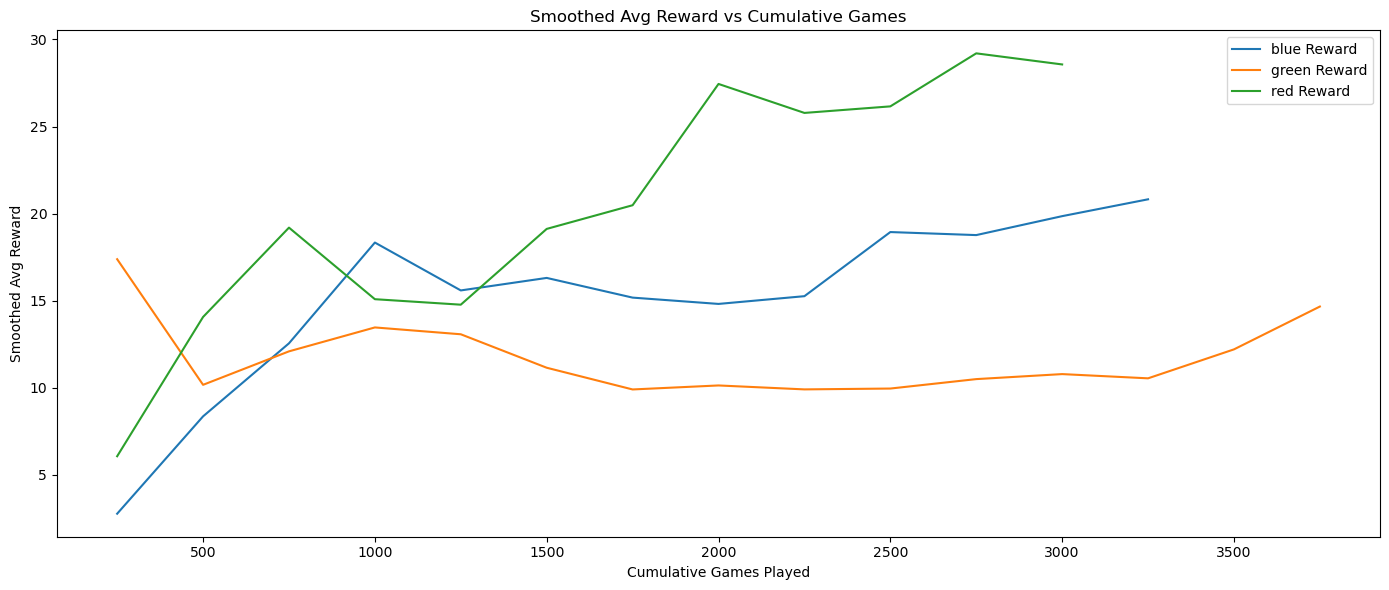

In [13]:
# Plot smoothed reward
plt.figure(figsize=(14, 6))
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    plt.plot(model_data['cumulative_games'], model_data['smoothed_reward'], label=f"{model} Reward")
plt.title("Smoothed Avg Reward vs Cumulative Games")
plt.xlabel("Cumulative Games Played")
plt.ylabel("Smoothed Avg Reward")
plt.legend()
plt.tight_layout()
plt.savefig("smoothed_avg_reward.png", dpi=300)
plt.show()

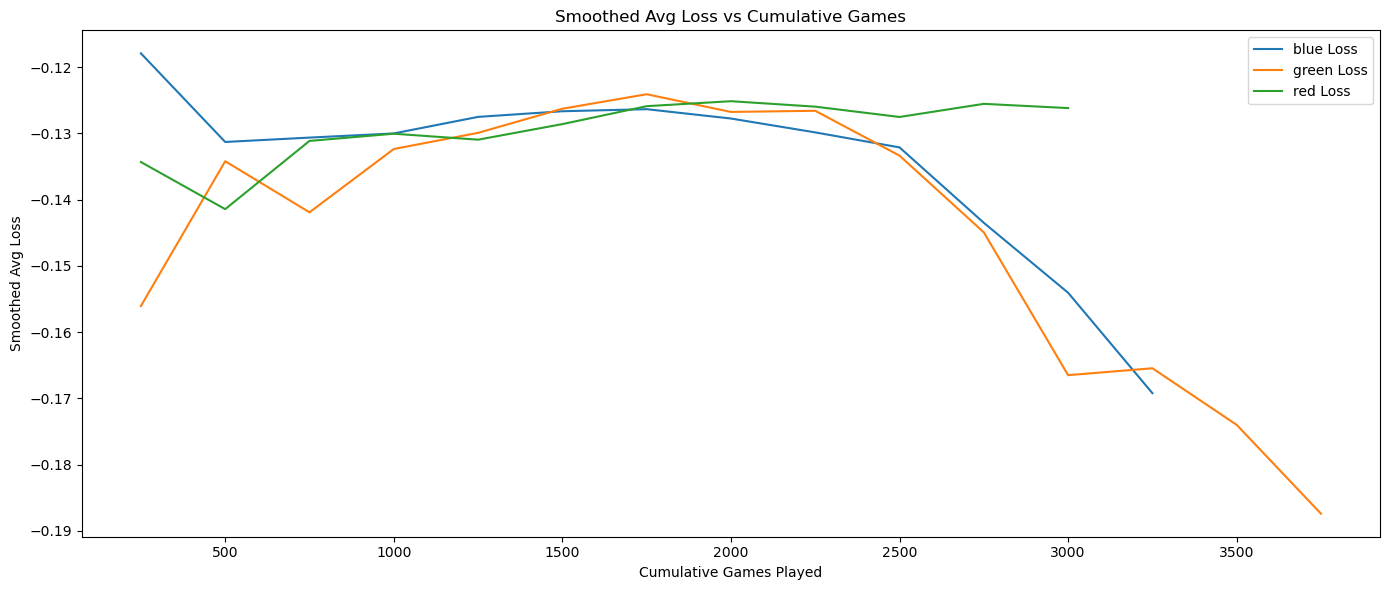

In [14]:
# Plot smoothed loss
plt.figure(figsize=(14, 6))
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    plt.plot(model_data['cumulative_games'], model_data['smoothed_loss'], label=f"{model} Loss")
plt.title("Smoothed Avg Loss vs Cumulative Games")
plt.xlabel("Cumulative Games Played")
plt.ylabel("Smoothed Avg Loss")
plt.legend()
plt.tight_layout()
plt.savefig("smoothed_avg_loss.png", dpi=300)
plt.show()

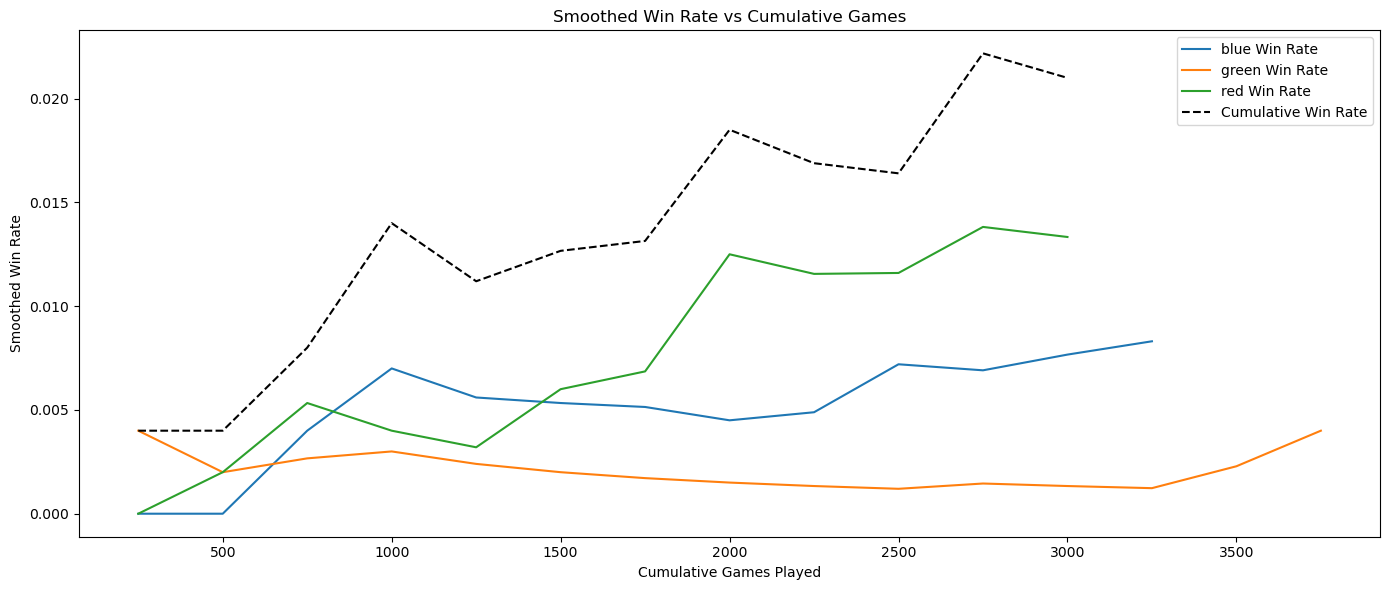

In [15]:
# Plot smoothed win rate
plt.figure(figsize=(14, 6))
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    plt.plot(model_data['cumulative_games'], model_data['smoothed_win_rate'], label=f"{model} Win Rate")

plt.plot(model_data['cumulative_games'], model_data['cumulative_win_rate'], label="Cumulative Win Rate", linestyle='--', color='black')

plt.title("Smoothed Win Rate vs Cumulative Games")
plt.xlabel("Cumulative Games Played")
plt.ylabel("Smoothed Win Rate")
plt.legend()
plt.tight_layout()
plt.savefig("smoothed_win_rate.png", dpi=300)
plt.show()

In [16]:
# Summary table per model
summary = df.groupby('model').agg({
    'cumulative_games': 'max',
    'cumulative_wins': 'max',
    'avg_reward': 'mean',
    'avg_loss': 'mean',
    'win_rate': 'mean'
}).rename(columns={
    'cumulative_games': 'Total Games',
    'cumulative_wins': 'Total Wins',
    'avg_reward': 'Avg Reward',
    'avg_loss': 'Avg Loss',
    'win_rate': 'Avg Win Rate'
})
summary['Win %'] = 100 * summary['Total Wins'] / summary['Total Games']
summary

,Total Games,Total Wins,Avg Reward,Avg Loss,Avg Win Rate,Win %
model,,,,,,
blue,3250,75,20.822147,-0.169207,0.008308,2.307692
green,3750,82,14.666127,-0.187392,0.004000,2.186667
red,3000,63,28.563998,-0.126189,0.013333,2.100000
